# Drive Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
BASE_PATH = "/content/drive/MyDrive/Emulator_Phase_2/"

# BASE_PATH = "/content/drive/MyDrive/BTP/Emulator_Phase_2/"
# BASE_PATH = "/content/drive/MyDrive/Projects_2021/Current_Projects/Varun_Projects/Pose/Emulator_Phase_2/"

In [ ]:
cd $BASE_PATH

/content/drive/.shortcut-targets-by-id/1K-2mjjQwqplpt6lUKZrjDWTFaM3_0nPS/Emulator_Phase_2


In [ ]:
# !unzip /content/drive/MyDrive/BTP/Emulator_Phase_2/Simulator_v2.8.4/results/v2.8.4_R0_Experiments.zip -d /content/drive/MyDrive/BTP/Emulator_Phase_2/Simulator_v2.8.4/results/

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 16.2 MB/s eta 0:00:00


# Parameters

In [4]:
args = { 
        # Filepaths 
        "PROJECT_DIR": BASE_PATH,
        "SAVE_DIR": "Emulator_Results/",
        "EXP_VERSION": "v3.11",
        "EXP_TYPE": "R0",
        "RAW_DATA_PATH": BASE_PATH + "Simulator_v1.7/results/v1.7_R0_Experiments/", # R0 -> Lockdown -> Population
        "DATA_PATH": BASE_PATH + "Simulator_v1.7/results/v1.7_R0_Sub_Grids_stride_5/", # R0 -> Lockdown -> Population
        "MAKE_SUB_GRIDS": False,
        "MODEL": "Dilated_CNN",

        "STRIDE_ROWS": 3,
        "STRIDE_COLS": 3,      

        # Simulation parameters
        "BLOCK_COUNT": 1000, # used for normalization
        "SIM_DAYS": 100,
        "NUM_STATS": 3,
        "STATS": ["cumulative_positive_tested", "current_hospitalized", "current_asymptomatic_free"],
        "NUM_BLOCK_PARAMETERS": 2,

        "CITY_GRID_ROWS": 20,
        "CITY_GRID_COLS": 20,

        "SUB_GRID_ROWS": 10,
        "SUB_GRID_COLS": 10,

        # Preprocessing parameters
        "LAG": 5,
        "FRAC_TRAIN_SERIES": 0.7,
        "FRAC_VAL_SERIES": 0.15,

        # Model parameters
        "CI": False,

        # Training parameters
        "SEED": 42,
        "LR": 3e-6,        
        "BATCH_SIZE": 64,
        "EPOCHS": 20,
}

In [ ]:
args["SAVE_PATH"]   = args["SAVE_DIR"] + args["EXP_VERSION"] + "/"
args["SAVE_DIR"]    = args["PROJECT_DIR"] + args["SAVE_DIR"]

if (args["MAKE_SUB_GRIDS"]==False):
    args["DATA_PATH"] = args["RAW_DATA_PATH"]

In [ ]:
args

{'PROJECT_DIR': '/content/drive/MyDrive/Emulator_Phase_2/',
 'SAVE_DIR': '/content/drive/MyDrive/Emulator_Phase_2/Emulator_Results/',
 'EXP_VERSION': 'v3.61',
 'EXP_TYPE': 'R0',
 'RAW_DATA_PATH': '/content/drive/MyDrive/Emulator_Phase_2/Simulator_v1.7/results/v1.7_R0_Experiments/',
 'DATA_PATH': '/content/drive/MyDrive/Emulator_Phase_2/Simulator_v1.7/results/v1.7_R0_Experiments/',
 'MAKE_SUB_GRIDS': False,
 'MODEL': '3D-CNN',
 'STRIDE_ROWS': 3,
 'STRIDE_COLS': 3,
 'BLOCK_COUNT': 1000,
 'SIM_DAYS': 100,
 'NUM_STATS': 3,
 'STATS': ['cumulative_positive_tested',
  'current_hospitalized',
  'current_asymptomatic_free'],
 'NUM_BLOCK_PARAMETERS': 2,
 'CITY_GRID_ROWS': 20,
 'CITY_GRID_COLS': 20,
 'SUB_GRID_ROWS': 10,
 'SUB_GRID_COLS': 10,
 'LAG': 5,
 'FRAC_TRAIN_SERIES': 0.7,
 'FRAC_VAL_SERIES': 0.15,
 'CI': False,
 'SEED': 42,
 'LR': 0.0003,
 'BATCH_SIZE': 64,
 'EPOCHS': 20,
 'SAVE_PATH': 'Emulator_Results/v3.61/'}

# Imports

In [ ]:
# !pip install autogluon
# !pip install "gluonts[mxnet,pro]"
# from gluonts.mx import DeepAREstimator, Trainer
# from gluonts.model.prophet import ProphetPredictor
# from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
# from gluonts.mx import DeepStateEstimator, Trainer

In [ ]:
import os
import glob
import time
import json
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from tensorflow import layers

from tensorflow.keras.models import Model, model_from_json
# from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import Input, GRU, Conv2D, Dropout, Flatten, Dense, Reshape, Concatenate, Add, MaxPooling2D, Conv2DTranspose

# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import TensorBoard

In [ ]:
random.seed(args["SEED"])
os.environ["PYTHONHASHSEED"]= str(args["SEED"])
np.random.seed(args["SEED"])
tf.random.set_seed(args["SEED"])

# Preprocessing

### Make Sub-Grids

In [ ]:
BIG_GRID_DATA_PATH = args["RAW_DATA_PATH"]
SUB_GRID_DATA_PATH = args["DATA_PATH"]

m = args["CITY_GRID_ROWS"]
n = args["CITY_GRID_COLS"]

h = args["SUB_GRID_ROWS"]
w = args["SUB_GRID_COLS"]

sh = args["STRIDE_ROWS"]
sw = args["STRIDE_COLS"]

In [ ]:
if (args["MAKE_SUB_GRIDS"]):
    big_sims = sorted(glob.glob("{}/*".format(BIG_GRID_DATA_PATH)))
    # os.makedirs(SUB_GRID_DATA_PATH, exist_ok=True)

    # load and save city_grids in a list
    city_grid_list = []
    for sdx, big_grid_path in tqdm(enumerate(big_sims), total=len(big_sims)):
        R0 = float(big_grid_path.split('_')[-3])
        grid_name = big_grid_path.split('/')[-1]
        if(R0 > 1.5):
          continue
        city_grid = np.load("{}/daily_city_grid.npy".format(big_grid_path))
        city_grid_list.append(city_grid)

    # track time to divide city_grid into sub_grids
    divide_times = []

    # partition city_grid into sub_grids
    sub_grid_list = []
    sub_grid_R0_list = []
    for sdx, big_grid_path in tqdm(enumerate(big_sims), total=len(big_sims)):
        
        start_time = time.time()

        R0 = float(big_grid_path.split('_')[-3])
        if(R0 > 1.5):
          continue
        # grid_name = big_grid_path.split('/')[-1]

        # sub_grid_path = SUB_GRID_DATA_PATH + str(R0) + "/"
        # os.makedirs(sub_grid_path, exist_ok=True)

        # city_grid = np.load("{}/daily_city_grid.npy".format(big_grid_path))
        city_grid = city_grid_list[sdx]

        kdx = 0
        for i in range(0, m-h+1, sh):
            for j in range(0, n-w+1, sw):
                if ((i+h-1+1>m) or (j+w-1+1>n)):
                    continue

                sub_grid = city_grid[:, i:i+h-1+1, j:j+w-1+1, :]
                sub_grid_list.append(sub_grid)
                sub_grid_R0_list.append(R0)

                # sub_grid_name = grid_name + str("_grid_{}".format(kdx))
                # with open(os.path.join(sub_grid_path, "{}.npy".format(sub_grid_name)), 'wb') as f:
                #     np.save(f, sub_grid)

                # store the sub_grids in a way such that we can use them later

                kdx += 1

        time_taken = time.time() - start_time
        divide_times.append(time_taken)
    
    print("--- average time to split a big grid into subgrids {:.4f} seconds ---".format(sum(divide_times)/len(divide_times)))

else: 
    print("this")
    sub_grid_list = sorted(glob.glob("{}/*/*.npy".format(args["DATA_PATH"])))
    sub_grid_R0_list = [float(sim_path.split('/')[-2].split('_')[2]) for sim_path in sub_grid_list]
    # R0 = f # for normal sims

this


In [ ]:
print(len(sub_grid_R0_list))
print(sub_grid_R0_list)

512
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 

In [ ]:
# sub_grid_R0_list_1 = [x for x in sub_grid_R0_list if x < 1.5]
# sub_grid_list_1 = sub_grid_list[:len(sub_grid_R0_list_1)]
# sub_grid_R0_list_2 = [x for x in sub_grid_R0_list if (x >= 1.5 and x < 2.0)]
# sub_grid_list_2 = sub_grid_list[len(sub_grid_R0_list_1):len(sub_grid_R0_list_1)+len(sub_grid_R0_list_2)]
# sub_grid_R0_list_3 = [x for x in sub_grid_R0_list if (x >= 2.0 and x <= 2.5)]
# sub_grid_list_3 = sub_grid_list[len(sub_grid_R0_list_1)+len(sub_grid_R0_list_2):len(sub_grid_R0_list_1)+len(sub_grid_R0_list_2)+len(sub_grid_R0_list_3)]

# print(len(sub_grid_list_1))
# print(len(sub_grid_list_2))
# print(len(sub_grid_list_3))

In [ ]:
args["DATA_PATH"]

'/content/drive/MyDrive/Emulator_Phase_2/Simulator_v1.7/results/v1.7_R0_Experiments/'

In [ ]:
# sub_grid.shape # size of each sub_grid

In [ ]:
print(sub_grid_list[0])

/content/drive/MyDrive/Emulator_Phase_2/Simulator_v1.7/results/v1.7_R0_Experiments/v1.7_R0_1.00_10_1/daily_city_grid.npy


### Load

In [ ]:
sub_grid_list = np.array(sub_grid_list)
sub_grid_R0_list = np.array(sub_grid_R0_list)

indices = np.arange(len(sub_grid_list))
np.random.shuffle(indices)

sub_grid_list = sub_grid_list[indices]
sub_grid_R0_list = sub_grid_R0_list[indices]

In [ ]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []
X_test_R0s = []

num_train_sims = round(args["FRAC_TRAIN_SERIES"]*len(sub_grid_list))
num_val_sims = round((args["FRAC_TRAIN_SERIES"]+args["FRAC_VAL_SERIES"])*len(sub_grid_list))

# for sdx, sim_path in tqdm(enumerate(sims), total=len(sims)):
for sdx in tqdm(range(len(sub_grid_list))):
    # daily_city_grid = np.load(sim_path)
    if (args["MAKE_SUB_GRIDS"]):
        daily_city_grid = sub_grid_list[sdx]
    else:
        daily_city_grid = np.load(sub_grid_list[sdx])
        # try:
        #     daily_city_grid = np.load(sub_grid_list[sdx])
        # except:
        #     print("skipping")
        #     pass
    sim_days = daily_city_grid.shape[0]

    # # add a day channel
    # day_channel = np.ones((daily_city_grid.shape[0], daily_city_grid.shape[1], daily_city_grid.shape[2], 1))
    # for i in range(day_channel.shape[0]):
    #     day_channel[i, :, :, :] = i
    # daily_city_grid = np.append(daily_city_grid, day_channel, axis=-1)

    # # REVERSED PREDICTIONS (v2.11.0)
    # daily_city_grid = np.flip(daily_city_grid, axis=0)

    # R0 = float(sim_path.split('/')[-2].split('_')[2]) # for normal sims
    # R0 = float(sim_path.split('/')[-2]) # for Simulator Scaling
    R0 = sub_grid_R0_list[sdx]

    xdx = 0
    for ydx in range(args["LAG"], sim_days):
        
        X = daily_city_grid[xdx:ydx, :, :, :].copy()    
        y = daily_city_grid[ydx, :, :, :args["NUM_STATS"]].copy()

        if (sdx+1 <= num_train_sims):
            X_train.append(X)
            y_train.append(y)

        elif (sdx+1 <= num_val_sims):
            X_val.append(X)
            y_val.append(y)
        
        else:
            X_test.append(X)
            y_test.append(y)

        xdx += 1
    
    if (sdx+1 > num_val_sims):
        X_test_R0s.append(R0)

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
X_train = np.array(X_train)
X_train.shape
# shape description -> (number of sequences, length of seq, 10*10 grid, 3 metrics + 2 parameters)

(34010, 5, 10, 10, 5)

In [ ]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)

# X_val = np.array(X_val)
# y_val = np.array(y_val)

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
# print(X_test.shape, y_test.shape)

X_train = X_train/args["BLOCK_COUNT"]

# if day channel
# X_train[:, :, :, :, -1] = X_train[:, :, :, :, -1]*10
# X_train[:, :, :, :, -2] = X_train[:, :, :, :, -2]*args["BLOCK_COUNT"]

# main
X_train[:, :, :, :, -1] = X_train[:, :, :, :, -1]*args["BLOCK_COUNT"]

# while running lockdown experiments
# X_train[:, :, :, :, -3] = X_train[:, :, :, :, -3]*args["BLOCK_COUNT"] 
y_train = np.array(y_train)/args["BLOCK_COUNT"]

X_val = np.array(X_val)/args["BLOCK_COUNT"]

# if day channel
# X_val[:, :, :, :, -1] = X_val[:, :, :, :, -1]*10
# X_val[:, :, :, :, -2] = X_val[:, :, :, :, -2]*args["BLOCK_COUNT"]

# main
X_val[:, :, :, :, -1] = X_val[:, :, :, :, -1]*args["BLOCK_COUNT"]

# while running lockdown experiments
# X_val[:, :, :, :, -3] = X_val[:, :, :, :, -3]*args["BLOCK_COUNT"] 

y_val = np.array(y_val)/args["BLOCK_COUNT"]

X_test = np.array(X_test)/args["BLOCK_COUNT"]

# if day channel
# X_test[:, :, :, :, -1] = X_test[:, :, :, :, -1]*10
# X_test[:, :, :, :, -2] = X_test[:, :, :, :, -2]*args["BLOCK_COUNT"]

# main
X_test[:, :, :, :, -1] = X_test[:, :, :, :, -1]*args["BLOCK_COUNT"]

# while running lockdown experiments
# X_test[:, :, :, :, -3] = X_test[:, :, :, :, -3]*args["BLOCK_COUNT"] 

y_test = np.array(y_test)/args["BLOCK_COUNT"]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# X_train = np.array(X_train)
# X_train = X_train/np.mean(X_train, axis=(0, 1))
# y_train = np.array(y_train)
# y_train = y_train/np.mean(y_train, axis=0)

# X_val = np.array(X_val)
# X_val = X_val/np.mean(X_val, axis=(0, 1))
# y_val = np.array(y_val)
# y_val = y_val/np.mean(y_val, axis=0)

# X_test = np.array(X_test)
# X_test = X_test/np.mean(X_test, axis=(0, 1))
# y_test = np.array(y_test)
# y_test = y_test/np.mean(y_test, axis=0)

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
# print(X_test.shape, y_test.shape)

(34010, 5, 10, 10, 5) (34010, 10, 10, 3)
(7315, 5, 10, 10, 5) (7315, 10, 10, 3)
(7315, 5, 10, 10, 5) (7315, 10, 10, 3)


### Data Visualization

In [ ]:
# pred_len = args["SIM_DAYS"]-args["LAG"] 
# offset = pred_len*(200-1) # the number denotes the series that will be visualized

# subplot_rows = pred_len//args["LAG"] 
# subplot_cols = args["LAG"] + 1

# fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 95))
# for xdx, idx in enumerate(range(offset, offset+pred_len, args["LAG"])):
#     for ydx in range(0, args["LAG"]):
#         ax[xdx, ydx].imshow(X_train[idx, ydx, :, :, 0], vmin=0, vmax=1)
#         ax[xdx, ydx].axis("off")
#         ax[xdx, ydx].title.set_text("x_{}".format(ydx+1))
    
#     ax[xdx, args["LAG"]].imshow(y_train[idx, :, :, 0], vmin=0, vmax=1)
#     ax[xdx, args["LAG"]].axis("off")
#     ax[xdx, args["LAG"]].title.set_text("y")

#### cumulative_positive_tested

X_train

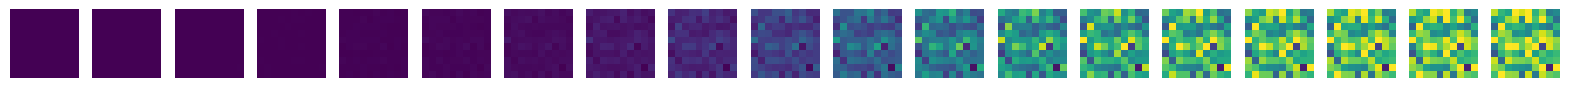

In [ ]:
pred_len = args["SIM_DAYS"]-args["LAG"] 

subplot_rows = 1
subplot_cols = pred_len//args["LAG"] 

fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 5))
for xdx, idx in enumerate(range(0, pred_len, args["LAG"])):
    ax[xdx].imshow(X_train[idx, 0, :, :, 0], vmin=0, vmax=1)
    ax[xdx].axis('off')

y_train

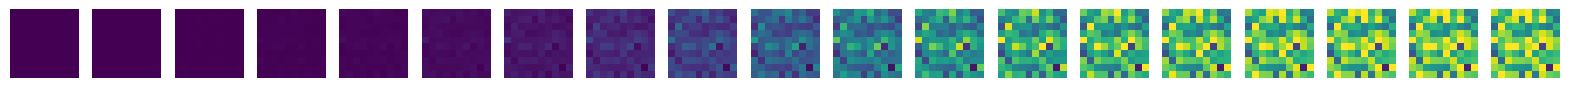

In [ ]:
pred_len = args["SIM_DAYS"]-args["LAG"] 

subplot_rows = 1
subplot_cols = pred_len//args["LAG"] 

fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 5))
for xdx, idx in enumerate(range(0, pred_len, args["LAG"])):
    ax[xdx].imshow(y_train[idx, :, :, 0], vmin=0, vmax=1)
    ax[xdx].axis('off')

#### current_hospitalized

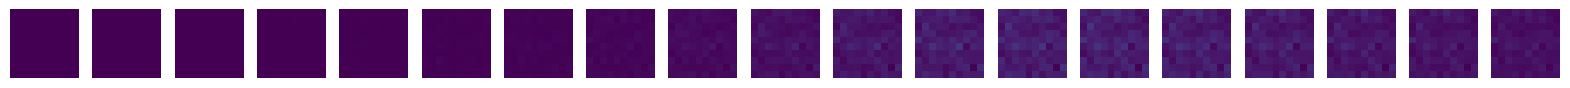

In [ ]:
pred_len = args["SIM_DAYS"]-args["LAG"] 

subplot_rows = 1
subplot_cols = pred_len//args["LAG"] 

fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 5))
for xdx, idx in enumerate(range(0, pred_len, args["LAG"])):
    ax[xdx].imshow(X_train[idx, 0, :, :, 1], vmin=0, vmax=1)
    ax[xdx].axis('off')

#### current_asymptomatic_free

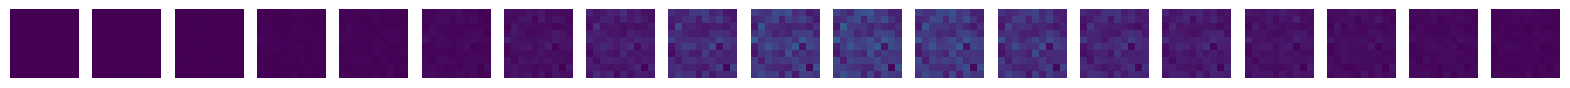

In [ ]:
pred_len = args["SIM_DAYS"]-args["LAG"] 

subplot_rows = 1
subplot_cols = pred_len//args["LAG"] 

fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 5))
for xdx, idx in enumerate(range(0, pred_len, args["LAG"])):
    ax[xdx].imshow(X_train[idx, 0, :, :, 2], vmin=0, vmax=1)
    ax[xdx].axis('off')

# Model

## Model Definition 

### ConvLSTM with (CI predictions)

In [ ]:
# if (args["MODEL"]=="ConvLSTM_CI"):
inp = layers.Input(shape=(args["LAG"], args["SUB_GRID_ROWS"], args["SUB_GRID_COLS"], args["NUM_STATS"] + args["NUM_BLOCK_PARAMETERS"]))
#print(tf.shape(inp))
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="valid",
    return_sequences=True,
    activation="sigmoid")(inp)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="valid",
    return_sequences=True,
    activation="sigmoid")(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="valid",
    return_sequences=True,
    activation="sigmoid")(x)

x = layers.Flatten()(x)

# x = layers.Dense(10000, activation="sigmoid")(x)
x = layers.Dense(1000, activation="sigmoid")(x)


if args["CI"] is True:
  x = layers.Dense(args["SUB_GRID_ROWS"]*args["SUB_GRID_COLS"]*args["NUM_STATS"]*2, activation="sigmoid")(x)
  x = layers.Reshape((args["SUB_GRID_ROWS"], args["SUB_GRID_COLS"], args["NUM_STATS"], 2))(x)
  x = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :, :, :, 0], scale=0.01*tf.math.softplus(t[:, :, :, :, 1])), convert_to_tensor_fn=tfd.Distribution.sample, name='normal_dist')(x) # note this (CI)
else:
  x = layers.Dense(args["SUB_GRID_ROWS"]*args["SUB_GRID_COLS"]*args["NUM_STATS"], activation="sigmoid")(x)
  x = layers.Reshape((args["SUB_GRID_ROWS"], args["SUB_GRID_COLS"], args["NUM_STATS"]))(x)

model = keras.models.Model(inp, x)

model.summary()    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 10, 10, 5)]    0         
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 5, 6, 6, 64)       441856    
                                                                 
 batch_normalization_5 (Batc  (None, 5, 6, 6, 64)      256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 5, 4, 4, 64)       295168    
                                                                 
 batch_normalization_6 (Batc  (None, 5, 4, 4, 64)      256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 5, 4, 4, 64)       3302

### Dilated CNN

In [ ]:
if (args["MODEL"]=="Dilated_CNN"):
  inp = layers.Input(shape=(X_train.shape[1:]))

  x = layers.Conv2D(
      filters=256,
      kernel_size=(5, 5),
      padding='valid', 
      strides=1, 
      activation='relu',
      dilation_rate=1)(inp)

  x = layers.Conv2D(
      filters=128,
      kernel_size=(3, 3),
      padding='valid', 
      strides=1, 
      activation='relu',
      dilation_rate=2)(x)

  x = layers.Conv2D(
      filters=64,
      kernel_size=(1, 1),
      padding='valid', 
      strides=1, 
      activation='relu',
      dilation_rate=4)(x)

  x = layers.Flatten()(x)

  x = layers.Dense(1000, activation="relu")(x)

  if args["CI"] is True:
    x = layers.Dense(X_train.shape[2]*X_train.shape[3]*args["NUM_STATS"]*2, activation="sigmoid")(x)
    x = layers.Reshape((X_train.shape[2], X_train.shape[3], args["NUM_STATS"], 2))(x)
    x = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :, :, :, 0], scale=0.01*tf.math.softplus(t[:, :, :, :, 1])), convert_to_tensor_fn=tfd.Distribution.sample, name='normal_dist')(x) # note this (CI)
  else:
    x = layers.Dense(X_train.shape[2]*X_train.shape[3]*args["NUM_STATS"], activation='sigmoid')(x)
    x = layers.Reshape((X_train.shape[2], X_train.shape[3], args["NUM_STATS"]))(x)

  model = keras.models.Model(inp, x)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 10, 10, 5)]    0         
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 6, 6, 256)      32256     
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 2, 2, 128)      295040    
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 2, 2, 64)       8256      
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1281000   
                                                                 
 dense_3 (Dense)             (None, 300)               3003

### 3D-CNN

In [ ]:
# if (args["MODEL"]=="3D-CNN"):

inputs = layers.Input(shape=(X_train.shape[1:]))

x = layers.Conv3D(filters=128, kernel_size=2, activation="relu")(inputs)
x = layers.MaxPool3D(pool_size=1)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=256, kernel_size=2, activation="relu")(x)
x = layers.MaxPool3D(pool_size=1)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=512, kernel_size=2, activation="relu")(x)
x = layers.MaxPool3D(pool_size=1)(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(units=1024, activation="relu")(x)
x = layers.Dropout(0.3)(x)

if args["CI"] is True:
  x = layers.Dense(X_train.shape[2]*X_train.shape[3]*args["NUM_STATS"]*2, activation='sigmoid')(x)
  x = layers.Reshape((X_train.shape[2], X_train.shape[3], args["NUM_STATS"], 2))(x)
  x = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :, :, :, 0], scale=0.01*tf.math.softplus(t[:, :, :, :, 1])), convert_to_tensor_fn=tfd.Distribution.sample, name='normal_dist')(x) # note this (CI)
else:
  x = layers.Dense(X_train.shape[2]*X_train.shape[3]*args["NUM_STATS"], activation='sigmoid')(x)
  x = layers.Reshape((X_train.shape[2], X_train.shape[3], args["NUM_STATS"]))(x)

model = keras.Model(inputs, x, name="3dcnn")

model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 10, 10, 5)]    0         
                                                                 
 conv3d_3 (Conv3D)           (None, 4, 9, 9, 128)      5248      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 4, 9, 9, 128)     0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 4, 9, 9, 128)     512       
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 8, 8, 256)      262400    
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 8, 8, 256)     0     

## Compile Model

In [ ]:
# mse = tf.keras.losses.MeanSquaredError()

# def temporal_loss(true_heatmap, pred_heatmap):
#     return mse(tf.reduce_sum(true_heatmap, axis=(1, 2)), tf.reduce_sum(pred_heatmap, axis=(1, 2)))

In [ ]:
# def kl(x, y):
#     X = tfp.distributions.Categorical(probs=x)
#     Y = tfp.distributions.Categorical(probs=y)
#     return tfp.experimental.nn.losses.kl_divergence_monte_carlo(X, Y)

In [ ]:
from keras import backend as K

def mse_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true)) * (1.5 + K.sign(y_true - y_pred))

In [ ]:
def mae_loss(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true)) * (1.5 + K.sign(y_true - y_pred))

In [ ]:
if (args["CI"] == True):
    loss = lambda y, p_y: -p_y.log_prob(y) # note this (CI)
else:
    loss = keras.losses.mean_squared_error # temporal_loss

optimizer = keras.optimizers.Adam(learning_rate=args["LR"])
model.compile(loss=loss, optimizer=optimizer)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 10, 10, 5)]    0         
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 6, 6, 256)      32256     
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 2, 2, 128)      295040    
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 2, 2, 64)       8256      
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1281000   
                                                                 
 dense_3 (Dense)             (None, 300)               3003

In [ ]:
args["SAVE_DIR"]+args["EXP_VERSION"]

'Emulator_Results/v3.11'

## Other models

### Autoencoders

In [ ]:
if (args["MODEL"]=="ae"):
    inp = layers.Input(shape=(10, 10, 5))
    print(inp.shape)
    
    # 10 -> 5 -> 2 -> 5 -> 10
    
    conv1 = Conv2D(12, (3, 3), activation="relu", padding="same")(inp)
    conv1 = Conv2D(12, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    #print(pool1.shape)
    
    # standard size 64 -> 32       custome size 50 -> 25
    conv2 = Conv2D(24, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(24, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    #print(pool2.shape)
    
    # Middle
    convm = Conv2D(24, (3, 3), activation="relu", padding="same")(pool2)
    convm = Conv2D(24, (3, 3), activation="relu", padding="same")(convm)
    #print(convm.shape)
    
    deconv2 = layers.Conv2DTranspose(24, (3, 3), strides=(2, 2), padding="valid")(convm)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(24, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(24, (3, 3), activation="relu", padding="same")(uconv2)
    #print(uconv2.shape)
    deconv1 = layers.Conv2DTranspose(12, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(12, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(12, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = keras.models.Model(inp, output_layer)

    model.summary()    

(None, 10, 10, 5)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 5)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 10, 10, 12)   552         ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 10, 10, 12)   1308        ['conv2d_11[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 5, 5, 12)    0           ['conv2d_12[0][0]']              
                                                                          

### TrajGRU

In [ ]:
# def get_pixel_value(img, x, y):
#     """
#     Utility function to get pixel value for coordinate
#     vectors x and y.
#     Input
#     -----
#     - img: tensor of shape (B, H, W, C)
#     - x: flattened tensor of shape (B, H, W)
#     - y: flattened tensor of shape (B, H, W)
#     Returns
#     -------
#     - output: tensor of shape (B, H, W, C)
#     """
#     shape = tf.shape(x)
#     batch_size = shape[0]
#     height = shape[1]
#     width = shape[2]

#     batch_idx = tf.range(0, batch_size)
#     batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
#     b = tf.tile(batch_idx, (1, height, width))

#     indices = tf.stack([b, y, x], 3)

#     return tf.gather_nd(img, indices)


# def wrap(img, x, y):
#     """
#     Performs bilinear sampling of the input images according to the
#     normalized coordinates provided by the sampling grid. Note that
#     the sampling is done identically for each channel of the input.
#     To test if the function works properly, output image should be
#     identical to input image when theta is initialized to identity
#     transform.
#     Input
#     -----
#     - img: batch of images in (B, H, W, C) layout.
#     - x of shape (B, H, W): elements of x are in [-1,1].
#     - y of shape (B, H, W): elements of y are in [-1,1]
#     Returns
#     -------
#     - out of shape (B, H, W, C): interpolated images according to grids x and y.
#     """
#     H = tf.shape(img)[1]
#     W = tf.shape(img)[2]
#     max_y = tf.cast(H - 1, 'int32')
#     max_x = tf.cast(W - 1, 'int32')
#     zero = tf.zeros([], dtype='int32')

#     # rescale x and y to [0, W-1/H-1]
#     x = tf.cast(x, 'float32')
#     y = tf.cast(y, 'float32')
#     x = 0.5 * ((x + 1.0) * tf.cast(max_x - 1, 'float32'))
#     y = 0.5 * ((y + 1.0) * tf.cast(max_y - 1, 'float32'))

#     # grab 4 nearest corner points for each (x_i, y_i)
#     x0 = tf.cast(tf.floor(x), 'int32')
#     x1 = x0 + 1
#     y0 = tf.cast(tf.floor(y), 'int32')
#     y1 = y0 + 1

#     # clip to range [0, H-1/W-1] to not violate img boundaries
#     x0 = tf.clip_by_value(x0, zero, max_x)
#     x1 = tf.clip_by_value(x1, zero, max_x)
#     y0 = tf.clip_by_value(y0, zero, max_y)
#     y1 = tf.clip_by_value(y1, zero, max_y)

#     # get pixel value at corner coords
#     Ia = get_pixel_value(img, x0, y0)
#     Ib = get_pixel_value(img, x0, y1)
#     Ic = get_pixel_value(img, x1, y0)
#     Id = get_pixel_value(img, x1, y1)

#     # recast as float for delta calculation
#     x0 = tf.cast(x0, 'float32')
#     x1 = tf.cast(x1, 'float32')
#     y0 = tf.cast(y0, 'float32')
#     y1 = tf.cast(y1, 'float32')

#     # calculate deltas
#     wa = (x1 - x) * (y1 - y)
#     wb = (x1 - x) * (y - y0)
#     wc = (x - x0) * (y1 - y)
#     wd = (x - x0) * (y - y0)

#     # add dimension for addition
#     wa = tf.expand_dims(wa, axis=3)
#     wb = tf.expand_dims(wb, axis=3)
#     wc = tf.expand_dims(wc, axis=3)
#     wd = tf.expand_dims(wd, axis=3)

#     # compute output
#     out = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])

#     return out


# class BaseConvRNN(keras.Model):
#     def __init__(self, num_filter, b_h_w,
#                  h2h_kernel=(3, 3), h2h_dilate=(1, 1),
#                  i2h_kernel=(3, 3), i2h_stride=(1, 1),
#                  i2h_pad=(1, 1), i2h_dilate=(1, 1),
#                  act_type=tf.math.tanh,
#                  prefix='BaseConvRNN'):
#         super(BaseConvRNN, self).__init__()
#         self._prefix = prefix
#         self._num_filter = num_filter
#         self._h2h_kernel = h2h_kernel
#         assert (self._h2h_kernel[0] % 2 == 1) and (self._h2h_kernel[1] % 2 == 1), \
#             "Only support odd number, get h2h_kernel= %s" % str(h2h_kernel)

#         self._h2h_dilate = h2h_dilate
#         self._i2h_kernel = i2h_kernel
#         self._i2h_stride = i2h_stride
#         self._i2h_pad = i2h_pad
#         self._i2h_dilate = i2h_dilate
#         self._act_type = act_type
#         assert len(b_h_w) == 3
#         i2h_dilate_ksize_h = 1 + (self._i2h_kernel[0] - 1) * self._i2h_dilate[0]
#         i2h_dilate_ksize_w = 1 + (self._i2h_kernel[1] - 1) * self._i2h_dilate[1]

#         self._batch_size, self._height, self._width = b_h_w

#         self._state_height = (self._height + 2 * self._i2h_pad[0] - i2h_dilate_ksize_h) \
#                              // self._i2h_stride[0] + 1
#         self._state_width = (self._width + 2 * self._i2h_pad[1] - i2h_dilate_ksize_w) \
#                             // self._i2h_stride[1] + 1

# class TrajGRU(BaseConvRNN):
#     def __init__(self, num_filter, b_h_w, zoneout=0.0, L=5,
#                  i2h_kernel=(3, 3), i2h_stride=(1, 1), i2h_pad=(1, 1),
#                  h2h_kernel=(5, 5), h2h_dilate=(1, 1),
#                  act_type=tf.nn.leaky_relu):
#         """
#         Input
#         ------
#         - num_filter: hidden size
#         - b_h_w: tuple of (B, H, W)
#         - zoneout: dropout
#         - L: number of links
#         - i2h_kernel: 2D tuple, input to hidden
#         - i2h_stride: 2D tuple, input to hidden
#         - i2h_pad: 2D tuple, input to hidden
#         - h2h_kernel: 2D tuple, hidden to hidden
#         - h2h_dilate: 2D tuple, hidden to hidden
#         - act_type: type of activation function
#         """
#         super(TrajGRU, self).__init__(num_filter=num_filter,
#                                       b_h_w=b_h_w,
#                                       h2h_kernel=h2h_kernel,
#                                       h2h_dilate=h2h_dilate,
#                                       i2h_kernel=i2h_kernel,
#                                       i2h_pad=i2h_pad,
#                                       i2h_stride=i2h_stride,
#                                       act_type=act_type,
#                                       prefix='TrajGRU')
#         self._L = L
#         self._zoneout = zoneout

#         # Computational part of Xt
#         self.i2h = keras.layers.Conv2D(filters=self._num_filter * 3,
#                                        kernel_size=self._i2h_kernel,
#                                        strides=self._i2h_stride,
#                                        padding="same",
#                                        dilation_rate=self._i2h_dilate)

#         # inputs to flow
#         self.i2f_conv1 = keras.layers.Conv2D(filters=32,
#                                              kernel_size=(5, 5),
#                                              strides=1,
#                                              padding="same",
#                                              dilation_rate=(1, 1))

#         # hidden to flow
#         self.h2f_conv1 = keras.layers.Conv2D(filters=32,
#                                              kernel_size=(5, 5),
#                                              strides=1,
#                                              padding="same",
#                                              dilation_rate=(1, 1))

#         # generate flow
#         self.flows_conv = keras.layers.Conv2D(filters=self._L * 2,
#                                               kernel_size=(5, 5),
#                                               strides=1,
#                                               padding="same")

#         # Computational part of Ht
#         self.ret = keras.layers.Conv2D(filters=self._num_filter * 3,
#                                        kernel_size=(1, 1),
#                                        strides=1)

#     def _flow_generator(self, inputs, states):
#         """
#         Generating flow images, which are also called sampling grids.
#         Input
#         ------
#         - inputs of shape (B, H, W, C): inputs
#         - states of shape (B, H, W, C): previous hidden states
#         Return
#         ------
#         - flow of shape (L, B, H, W, 2): L*2 flow images, which are also called sampling grids
#         """
#         if inputs is not None:
#             i2f_conv1 = self.i2f_conv1(inputs)
#         else:
#             i2f_conv1 = None
#         h2f_conv1 = self.h2f_conv1(states)
#         f_conv1 = i2f_conv1 + h2f_conv1 if i2f_conv1 is not None else h2f_conv1  # 这里看，inputs的H，W和state的H，W应该一样
#         f_conv1 = self._act_type(f_conv1, alpha=0.2)

#         flows = self.flows_conv(f_conv1)  # size<B, H, W, 2*L>
#         flows = tf.split(flows, num_or_size_splits=self._L, axis=3)  # 第1维分割，2个一组 size<L, B, H, W, 2>
#         return flows

#     def call(self, inputs=None, states=None):
#         """
#         TrajGRU
#         Input
#         ------
#         - inputs of shape (S, B, H, W, C): inputs
#         - state of shape (B, H, W, C): previous hidden states
#         Return
#         ------
#         - tf.stack(outputs) of shape (S, B, H, W, hidden_size): history hidden states
#         - next_h of shape (B, H, W, hidden_size): output
#         ------
#         """
#         seq_len = tf.shape(inputs).numpy()[0]
#         if states is None:
#             states = tf.zeros((tf.shape(inputs).numpy()[1], self._state_height,
#                                self._state_width, self._num_filter))
#             states = tf.cast(states, 'float32')
#         if inputs is not None:
#             S, B, H, W, C = tf.shape(inputs).numpy()
#             i2h = self.i2h(tf.reshape(inputs, (-1, H, W, C)))
#             i2h = tf.reshape(i2h, (S, B, tf.shape(i2h).numpy()[1], tf.shape(i2h).numpy()[2],
#                                    tf.shape(i2h).numpy()[3]))
#             i2h_slice = tf.split(i2h, num_or_size_splits=3, axis=4)

#         else:
#             i2h_slice = None

#         prev_h = states
#         outputs = []
#         for i in range(seq_len):
#             if inputs is not None:
#                 flows = self._flow_generator(inputs[i, ...], prev_h)
#             else:
#                 flows = self._flow_generator(None, prev_h)
#             wrapped_data = []
#             for j in range(len(flows)):
#                 flow = flows[j]
#                 wrapped_data.append(wrap(prev_h, -flow[:, :, :, 0], -flow[:, :, :, 1]))

#             wrapped_data = tf.concat(wrapped_data, axis=3)
#             h2h = self.ret(wrapped_data)
#             h2h_slice = tf.split(h2h, 3, axis=3)

#             if i2h_slice is not None:
#                 reset_gate = tf.math.sigmoid(i2h_slice[0][i, ...] + h2h_slice[0])
#                 update_gate = tf.math.sigmoid(i2h_slice[1][i, ...] + h2h_slice[1])
#                 new_mem = self._act_type(i2h_slice[2][i, ...] + reset_gate * h2h_slice[2], alpha=0.2)
#             else:
#                 reset_gate = tf.math.sigmoid(h2h_slice[0])
#                 update_gate = tf.math.sigmoid(h2h_slice[1])
#                 new_mem = self._act_type(reset_gate * h2h_slice[2], alpha=0.2)
#             next_h = update_gate * prev_h + (1 - update_gate) * new_mem

#             if self._zoneout > 0.0:
#                 mask = tf.nn.dropout(tf.zeros_like(prev_h), rate=self._zoneout)
#                 next_h = tf.where(mask, next_h, prev_h)
#             outputs.append(next_h)
#             prev_h = next_h

#         return tf.stack(outputs), next_h

In [ ]:
# tf.executing_eagerly()

True

In [ ]:
# s = tf.shape([[1,1,1,1], [1,2,2,2], [1,2,2,2]]).numpy()[0]
# s

3

In [ ]:
# model = TrajGRU()
# model.build(X_train.shape)
# model.summary()

AttributeError: ignored

In [ ]:
# model(10, 10)

IndexError: ignored

### Gluon Models

In [ ]:
# 'DATA_PATH': '/content/drive/MyDrive/Emulator_Phase_2/Simulator_v1.7/results/v1.7_R0_Experiments/'

In [ ]:
# temporal_result_paths = glob.glob(args["DATA_PATH"] + "*/results_df.csv")
# temporal_result_paths[0]

'/content/drive/MyDrive/Emulator_Phase_2/Simulator_v1.7/results/v1.7_R0_Experiments/v1.7_R0_1.00_1_2/results_df.csv'

In [ ]:
# temporal_result_paths = glob.glob(args["DATA_PATH"] + "*/results_df.csv")
# df_cpt = pd.DataFrame()
# for idx, df_path in tqdm(enumerate(temporal_result_paths), total=len(temporal_result_paths)):
#     df_t = pd.read_csv(df_path)
#     df_t["idx"] = pd.date_range(start='01/01/2020', periods=100)
#     df_t["R0"] = float(temporal_result_paths[idx].split("/")[-2].split("_")[2])
#     df_t["series_idx"] = idx
#     df_cpt = pd.concat([df_cpt, df_t[["series_idx", "idx", "R0", "cumulative_positive_tested"]]], axis=0)

# df_cpt

  0%|          | 0/512 [00:00<?, ?it/s]

,series_idx,idx,R0,cumulative_positive_tested
0,0,2020-01-01,1.0,0
1,0,2020-01-02,1.0,0
2,0,2020-01-03,1.0,0
3,0,2020-01-04,1.0,2
4,0,2020-01-05,1.0,2
...,...,...,...,...
95,511,2020-04-05,2.5,81983
96,511,2020-04-06,2.5,81996
97,511,2020-04-07,2.5,82004
98,511,2020-04-08,2.5,82012


In [ ]:
# df_cpt = df_cpt.rename(columns={"series_idx": "item_id", "idx": "timestamp", "cumulative_positive_tested": "target"})
# df_cpt = df_cpt.loc[df_cpt["R0"] >= 2.0]
# df_cpt[["item_id", "timestamp", "target", "R0"]]

,item_id,timestamp,target,R0
0,320,2020-01-01,0,2.0
1,320,2020-01-02,0,2.0
2,320,2020-01-03,0,2.0
3,320,2020-01-04,2,2.0
4,320,2020-01-05,4,2.0
...,...,...,...,...
95,511,2020-04-05,81983,2.5
96,511,2020-04-06,81996,2.5
97,511,2020-04-07,82004,2.5
98,511,2020-04-08,82012,2.5


In [ ]:
# ts_dataframe = TimeSeriesDataFrame(
#     df_cpt[["item_id", "timestamp", "target", "R0"]], 
# )
# ts_dataframe

target   R0
item_id timestamp              
320     2020-01-01       0  2.0
        2020-01-02       0  2.0
        2020-01-03       0  2.0
        2020-01-04       2  2.0
        2020-01-05       4  2.0
...                    ...  ...
511     2020-04-05   81983  2.5
        2020-04-06   81996  2.5
        2020-04-07   82004  2.5
        2020-04-08   82012  2.5
        2020-04-09   82017  2.5

[19200 rows x 2 columns]

In [ ]:
# prediction_length = 1

# test_data = ts_dataframe  # the full data set

# # last prediction_length timesteps of each time series are excluded, akin to `x[:-48]`
# train_data = ts_dataframe.slice_by_timestep(None, -prediction_length)

In [ ]:
# estimator = ProphetPredictor(
#     prediction_length=prediction_length,
# )

In [ ]:
# # predictor.predict(
# #     train_data,
# #     presets="medium_quality",
# #     time_limit=600,
# #     hyperparameters={
# #         "prophet": {},
# #     },
# # )

# predictions = estimator.train(train_data)
# predictions.head()

## Training

### Callbacks

In [ ]:
# Add callbacks
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=1e-5,
    cooldown=0,
    min_lr=1e-8)

ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    args["SAVE_DIR"]+args["EXP_VERSION"]+"/best_model.hdf5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

callbacks = [ReduceLROnPlateau, ModelCheckpoint]

### Training Loop

In [ ]:
args["SAVE_DIR"]+args["EXP_VERSION"]+"/best_model.hdf5"

'/content/drive/MyDrive/Emulator_Phase_2/Emulator_Results/v3.23/best_model.hdf5'

In [ ]:
start_time = time.time()
count = 0
hist = model.fit(X_train, y_train, batch_size=args["BATCH_SIZE"], epochs=args["EPOCHS"], validation_data=(X_val, y_val), callbacks=callbacks, verbose=True, shuffle=False)

time_taken = time.time() - start_time
print("--- total {:.4f} seconds ---".format(time_taken))
print("--- per epoch {:.4f} seconds ---".format(time_taken/(args["EPOCHS"])))

In [ ]:
model.save(args["SAVE_DIR"]+args["EXP_VERSION"]+"/best_model.hdf5")

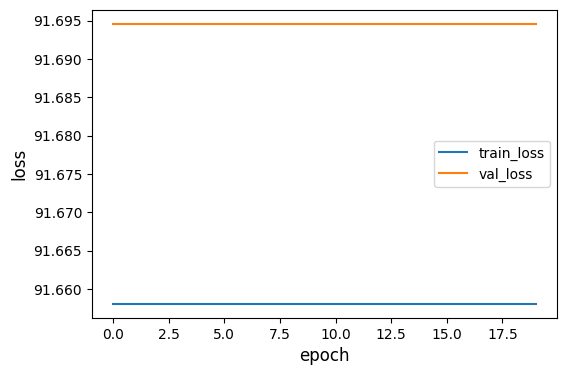

In [ ]:
plot_df = pd.DataFrame.from_dict({"train_loss":hist.history["loss"], "val_loss":hist.history["val_loss"]})
plot_df.plot(logy=False, figsize=(6,4))
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.savefig(args["SAVE_DIR"]+args["EXP_VERSION"]+"/train_val_loss.png")
plt.show()

In [ ]:
args["TOTAL_TRAINING_TIME"] = time_taken
args["TRAINING_TIME_PER_EPOCH"] = time_taken/args["EPOCHS"]
# args["INFERENCE_TIME_PER_SERIES"] = sum(times)/len(times)

with open(os.path.join(args["SAVE_DIR"]+args["EXP_VERSION"], "args.json"), 'w') as f:
    json.dump(args, f)

with open(os.path.join(args["SAVE_DIR"]+args["EXP_VERSION"], "hist.pkl"), 'wb') as f:
     pickle.dump(hist, f)

print(args["SAVE_DIR"]+args["EXP_VERSION"]+ "/hist.pkl")

Emulator_Results/v3.61/hist.pkl


# Evaluate

In [ ]:
# model = keras.models.load_model(args["SAVE_DIR"]+args["EXP_VERSION"]+"/best_model.hdf5", custom_objects={'temporal_loss': temporal_loss})
model = keras.models.load_model(args["SAVE_DIR"]+args["EXP_VERSION"]+"/best_model.hdf5", custom_objects={'loss': loss})

In [ ]:
args["SAVE_DIR"] + args["EXP_VERSION"] 

'Emulator_Results/v3.11'

In [ ]:
tf.keras.utils.plot_model(model, to_file = args["SAVE_DIR"] + args["EXP_VERSION"] + '/model_plot.png', show_shapes=True)

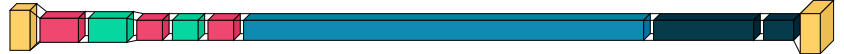

In [ ]:
import visualkeras
visualkeras.layered_view(model, to_file=args["SAVE_DIR"] + args["EXP_VERSION"] + '/model_pretty_plot.png').show() # write and show

In [ ]:
PLOTS_PATH = args["SAVE_DIR"] + args["EXP_VERSION"] + "/ci_plots" 

In [ ]:
PLOTS_PATH

'Emulator_Results/v3.11/ci_plots'

In [ ]:
#output.numpy().squeeze()
input = X_test.squeeze()[0:1].copy()
output = model(input)
print(input.shape, output.shape)
print(tf.squeeze(output).shape)
#print(y_test[i + j].squeeze().shape)

(1, 5, 10, 10, 5) (1, 10, 10, 3)
(10, 10, 3)


In [ ]:
def mape(y_true, y_pred):
  n = len(y_true)
  ans = 0
  for i in range(len(y_true)):
    if y_true[i]==0:
      ans += 0
    else:
      ans += abs(y_true[i]-y_pred[i])/y_true[i]
  return ans/n

In [ ]:
# since we cannot predict for the first lag days 
pred_len = args["SIM_DAYS"]-args["LAG"] 

times = []
temporal_mae_df = []
temporal_mape_df = []

for kdx, i in tqdm(enumerate(range(0, len(X_test), pred_len)), total=len(range(0, len(X_test), pred_len))):
    Exp_Param = X_test_R0s[kdx]
    # print(Exp_Param, i)
    if (os.path.exists(PLOTS_PATH + "/{}_{}".format(args["EXP_TYPE"], Exp_Param))):
        continue
    os.makedirs(PLOTS_PATH + "/{}_{}".format(args["EXP_TYPE"], Exp_Param), exist_ok=True)

    start_time = time.time()

    input = X_test.squeeze()[i:i+1].copy() # right exclusive means we only take one series
    # input = np.expand_dims(input, axis=0)
    # print("input shape", input.shape)
    # [1, 5, 10, 10, 5]
    preds = []
    actuals = []
    
    

    for j in range(0, pred_len):
        output = model(input)
        
        if args["CI"] is True:
          squeeze_output = tf.squeeze(output)
        else:
          squeeze_output = output.numpy().squeeze()
        # print("squeeze_output shape", squeeze_output.shape)
        
        preds.append(squeeze_output)  
        actuals.append(y_test[i + j].squeeze())

        # 1 = Horizon 
        input = np.roll(input, -1, axis=1)
        input[:, -1, :, :, :args["NUM_STATS"]] = squeeze_output
        input[:, -1, :, :, args["NUM_STATS"]:] = X_test[i+j, -1, :, :, args["NUM_STATS"]:]

    preds = np.array(preds)
    actuals = np.array(actuals)
    mse = {key: [] for key in args["STATS"]}
    temporal_mae = {key: [] for key in args["STATS"]}
    temporal_mape = {key: [] for key in args["STATS"]}

    # print(actuals.shape, preds.shape)

    time_taken = time.time() - start_time
    times.append(time_taken)

    for sdx, stat in enumerate(args["STATS"]):
        
        # ensure predictions are cumulative
        if (sdx == 0):
            temporal_preds = np.sum(preds, axis=(1, 2))[:, sdx]
            temporal_preds_rolled = np.roll(temporal_preds, 1)
            temporal_preds_rolled[0] = 0
            temporal_preds_rolled = temporal_preds - temporal_preds_rolled 
            temporal_preds_rolled = np.where(temporal_preds_rolled < 0, 0, temporal_preds_rolled).cumsum()

            temporal_actuals = np.sum(actuals, axis=(1, 2))[:, sdx]
            temporal_actuals_rolled = np.roll(temporal_actuals, 1)
            temporal_actuals_rolled[0] = 0
            temporal_actuals_rolled = temporal_actuals - temporal_actuals_rolled 
            temporal_actuals_rolled = np.where(temporal_actuals_rolled < 0, 0, temporal_actuals_rolled).cumsum()

            plt.plot(temporal_actuals_rolled, label='actual')
            plt.plot(temporal_preds_rolled, label='prediction')
            temporal_mae[stat].append(mean_absolute_error(temporal_preds_rolled, temporal_actuals_rolled))
            temporal_mape[stat].append(mape(temporal_actuals_rolled, temporal_preds_rolled))
            plt.fill_between(np.arange(0,95), (95*(np.mean(preds, axis=(1, 2))[:, sdx] + 1.645 * np.std(preds, axis=(1, 2))[:, sdx])), (95*(np.mean(preds, axis=(1, 2))[:, sdx] - 1.645 * np.std(preds, axis=(1, 2))[:, sdx])), color="red", alpha=0.1, label=f"90% confidence interval")    

        else:
            plt.plot(np.sum(actuals, axis=(1, 2))[:, sdx], label='actual')
            plt.plot(np.sum(preds, axis=(1, 2))[:, sdx], label='prediction')
            temporal_mae[stat].append(mean_absolute_error(np.sum(preds, axis=(1, 2))[:, sdx], np.sum(actuals, axis=(1, 2))[:, sdx]))
            temporal_mape[stat].append(mape(np.sum(preds, axis=(1, 2))[:, sdx], np.sum(actuals, axis=(1, 2))[:, sdx]))
            plt.fill_between(np.arange(0,95), (95*(np.mean(preds, axis=(1, 2))[:, sdx] + 1.645 * np.std(preds, axis=(1, 2))[:, sdx])), (95*(np.mean(preds, axis=(1, 2))[:, sdx] - 1.645 * np.std(preds, axis=(1, 2))[:, sdx])), color="red", alpha=0.1, label=f"90% confidence interval")    


        plt.legend()
        plt.tight_layout()
        plt.savefig(PLOTS_PATH + "/{}_{}/{}_temporal_plot.png".format(args["EXP_TYPE"], Exp_Param, stat))
        plt.close()

    # with open(args["SAVE_DIR"] + args["EXP_VERSION"] + "/plots_new/{}_{}/".format(args["EXP_TYPE"], Exp_Param) + 'preds.npy', 'wb') as f:
    #     np.save(f, preds)

    # with open(args["SAVE_DIR"] + args["EXP_VERSION"] + "/plots_new/{}_{}/".format(args["EXP_TYPE"], Exp_Param) + 'actuals.npy', 'wb') as f:
    #     np.save(f, actuals)

    # with open(args["SAVE_DIR"] + args["EXP_VERSION"] + "/plots_new/{}_{}/".format(args["EXP_TYPE"], Exp_Param) + 'mse.json', 'w') as f:
    #     json.dump(mse, f)

    # with open(args["SAVE_DIR"] + args["EXP_VERSION"] + "/plots_new/{}_{}/".format(args["EXP_TYPE"], Exp_Param) + 'temporal_mse.json', 'w') as f:
    #     json.dump(temporal_mse, f)
    
    temporal_mae["R0"] = Exp_Param
    temporal_mae["index"] = kdx
    temporal_mae_df.append(temporal_mae)

    temporal_mape["R0"] = Exp_Param
    temporal_mape["index"] = kdx
    temporal_mape_df.append(temporal_mape)
        
# print("--- per series {:.4f} seconds ---".format(sum(times)/len(times)))

  0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
temporal_mae_df = pd.DataFrame(temporal_mae_df)    
temporal_mae_df["cumulative_positive_tested"] = temporal_mae_df["cumulative_positive_tested"].apply(lambda x: x[0])
temporal_mae_df["current_hospitalized"] = temporal_mae_df["current_hospitalized"].apply(lambda x: x[0])
temporal_mae_df["current_asymptomatic_free"] = temporal_mae_df["current_asymptomatic_free"].apply(lambda x: x[0])
temporal_mae_df = temporal_mae_df.groupby(['R0']).mean().drop(columns=['index'])
temporal_mae_df

,cumulative_positive_tested,current_hospitalized,current_asymptomatic_free
R0,,,
1.0,1.715616,0.207016,0.364659
1.1,1.825180,0.237950,0.333192
1.2,1.555333,0.252836,0.487117
1.3,3.744174,0.326294,0.741508
1.4,1.624383,0.199136,0.412350
1.5,8.841819,0.923916,2.534150
1.6,0.958830,0.139773,0.364701
1.7,4.690030,0.604636,1.767717
1.8,5.410325,0.750064,1.987733


In [ ]:
print(temporal_mae_df["cumulative_positive_tested"].mean())
print(temporal_mae_df["current_hospitalized"].mean())
print(temporal_mae_df["current_asymptomatic_free"].mean())

3.800172950678907
0.5833293230870055
1.3580672338591593


In [ ]:
temporal_mape_df = pd.DataFrame(temporal_mape_df)
temporal_mape_df["cumulative_positive_tested"] = temporal_mape_df["cumulative_positive_tested"].apply(lambda x: x[0])
temporal_mape_df["current_hospitalized"] = temporal_mape_df["current_hospitalized"].apply(lambda x: x[0])
temporal_mape_df["current_asymptomatic_free"] = temporal_mape_df["current_asymptomatic_free"].apply(lambda x: x[0])
temporal_mape_df = temporal_mape_df.groupby(['R0']).mean().drop(columns=['index'])
temporal_mape_df

,cumulative_positive_tested,current_hospitalized,current_asymptomatic_free
R0,,,
1.0,3.534219,0.814195,0.526413
1.1,2.250324,0.513028,0.282803
1.2,9.838688,0.470160,0.332319
1.3,2.136823,0.321866,0.279111
1.4,1.904326,0.241586,0.157231
1.5,4.684144,0.511383,0.626674
1.6,1.153140,0.160870,0.119140
1.7,1.427758,0.333557,0.368940
1.8,1.310856,0.329686,0.386416


In [ ]:
print(temporal_mape_df["cumulative_positive_tested"].mean())
print(temporal_mape_df["current_hospitalized"].mean())
print(temporal_mape_df["current_asymptomatic_free"].mean())

2.261642675609871
0.36116438409583485
0.3564030219082644


In [ ]:
temporal_mae_df.to_csv(args["SAVE_DIR"] + args["EXP_VERSION"] + '/temporal_absolute_error.csv', index=False)
temporal_mape_df.to_csv(args["SAVE_DIR"] + args["EXP_VERSION"] + '/temporal_relative_error.csv', index=False)

In [ ]:
args["SAVE_DIR"]+args["EXP_VERSION"]

'/content/drive/MyDrive/BTP/Emulator_Phase_2/Emulator_Results/v1.7.5'

In [ ]:
os.path.join(args["SAVE_DIR"], args["EXP_VERSION"], "args.json")

'/content/drive/MyDrive/BTP/Emulator_Phase_2/Emulator_Results/v1.7.5/args.json'

In [ ]:
args["TOTAL_TRAINING_TIME"] = time_taken
args["TRAINING_TIME_PER_EPOCH"] = time_taken/args["EPOCHS"]
args["INFERENCE_TIME_PER_SERIES"] = sum(times)/len(times)

with open(os.path.join(args["SAVE_DIR"]+args["EXP_VERSION"], "args.json"), 'w') as f:
    json.dump(args, f)

with open(os.path.join(args["SAVE_DIR"]+args["EXP_VERSION"], "hist.pkl"), 'wb') as f:
    pickle.dump(hist, f)

In [ ]:
hist.history

In [ ]:
%cd /content/drive/MyDrive/Projects_2021/Current_Projects/Varun_Projects/Pose/Emulator_Phase_2/Emulator_Results/v2.7.1

In [ ]:
import src
from sklearn.metrics import mean_squared_error

In [ ]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
with open("config.json") as f:
    config = json.load(f)

In [ ]:
TRUE_R0 = 2.89

config_t = config.copy()
config_t["VIRUS_R0"] = TRUE_R0

simulation = src.Simulation_Module(config_t)
with HiddenPrints():
    cpt_true = simulation.Run_Simulation(save_dir="results/{}_R0_Experiments".format(config_t["SIM_VERSION"]), sim_name="{}_R0_{:.2f}".format(config_t["SIM_VERSION"], config_t["VIRUS_R0"]))

with open("results/{}_R0_Experiments/{}_R0_{:.2f}/daily_city_grid.npy".format(config_t["SIM_VERSION"], config_t["SIM_VERSION"], config_t["VIRUS_R0"]), 'rb') as f:
    true_daily_city_grid = np.load(f)

true_daily_city_grid = np.array(true_daily_city_grid)/1000
true_daily_city_grid[:, :, :, -1] = true_daily_city_grid[:, :, :, -1]*1000

true_daily_city_grid.shape

In [ ]:
# define an objective function
def objective(R0):
    config_t = config.copy()
    config_t["VIRUS_R0"] = R0
    config_t["MAX_R0"] = R0

    simulation = src.Simulation_Module(config_t)
    with HiddenPrints():
        cpt = simulation.Run_Simulation(save_dir="results/{}_R0_Experiments".format(config_t["SIM_VERSION"]), sim_name="{}_R0_{:.2f}".format(config_t["SIM_VERSION"], config_t["VIRUS_R0"]))

    return mean_squared_error(cpt_true, cpt)

In [ ]:
# define a search space
from hyperopt import hp
space = hp.uniform('R0', 1, 4)

In [ ]:
# minimize the objective over the space
from hyperopt import fmin, tpe
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

In [ ]:
model = keras.models.load_model("best_model.hdf5")

In [ ]:
input = np.expand_dims(true_daily_city_grid[:5, :, :, :], axis=0).copy()
input[:, :, :, :, -1] = 2.244

pred_len = 100 - 5
preds = []

for j in range(0, pred_len):
    output = model(input) 

    preds.append(output.numpy().squeeze())

    # 1 = Horizon 
    input = np.roll(input, -1, axis=1)
    input[:, -1, :, :, :3] = output.numpy()

preds = np.array(preds)

In [ ]:
for sdx, stat in enumerate(["cumulative_positive_tested", "current_hospitalized", "current_asymptomatic_free"]):
    subplot_rows = 2
    subplot_cols = pred_len//5
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 3))
    idx = 0
    for i in range(0, pred_len, 5):
        ax[0, idx].imshow(true_daily_city_grid[i+5, :, :, sdx], vmin=0, vmax=1)
        ax[0, idx].title.set_text("Act_{}".format(i+1))
        
        ax[1, idx].imshow(preds[i, :, :, sdx], vmin=0, vmax=1)
        ax[1, idx].title.set_text("Pred_{}".format(i+1))

        ax[0, idx].axis('off')
        ax[1, idx].axis('off')
        idx += 1

    fig.suptitle("{}_{}_{}".format('R0', TRUE_R0, stat))
    plt.show()
    # plt.savefig(args["SAVE_DIR"]+args["EXP_VERSION"]+"/plots/{}_{}/{}_predictions.png".format(args["EXP_TYPE"], Exp_Param, stat))
    # plt.close()
    # print("\n")

In [ ]:
# define an objective function
def objective(R0):
    input = np.expand_dims(true_daily_city_grid[:5, :, :, :], axis=0).copy()
    input[:, :, :, :, -1] = R0

    pred_len = 100 - 5
    preds = []

    for j in range(0, pred_len):
        output = model(input) 

        preds.append(output.numpy().squeeze())

        # 1 = Horizon 
        input = np.roll(input, -1, axis=1)
        input[:, -1, :, :, :3] = output.numpy()

    preds = np.array(preds)

    print('R0 = {:.2f}, MSE = {:.4f}'.format(R0, mean_squared_error(true_daily_city_grid[5:, :, :, 0].flatten(), preds[:, :, :, 0].flatten())))

    return mean_squared_error(true_daily_city_grid[5:, :, :, 0].flatten(), preds[:, :, :, 0].flatten())

In [ ]:
# define a search space
from hyperopt import hp
space = hp.uniform('R0', 1, 4)

In [ ]:
# minimize the objective over the space
from hyperopt import fmin, tpe
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

In [ ]:
print(best)

In [ ]:
import hyperopt
print(hyperopt.space_eval(space, best))